In [1]:
!pip install einops
!pip install fancy_einsum
!pip install sentence_transformers

import glob
import os
import sys
import time
from functools import wraps
from typing import Callable, Union, cast
import pandas as pd
import torch as t
from einops import rearrange, repeat
from fancy_einsum import einsum
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from transformers.models.clip import modeling_clip
from dataclasses import dataclass


  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=59da30616c3e0fa9d6c8077d0392a86291954e431ad7c20f8f640ad112c417ba
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


## Tester methods

In [18]:
from typing import TypeVar, Generic, Iterator
T = TypeVar("T")


class StaticModuleList(nn.ModuleList, Generic[T]):
    """ModuleList where the user vouches that it only contains objects of type T.

    This allows the static checker to work instead of only knowing that the contents are Modules.
    """

    # TBD lowpri: is it possible to do this just with signatures, without actually overriding the method bodies to add a cast?

    def __getitem__(self, index: int) -> T:
        return cast(T, super().__getitem__(index))

    def __iter__(self) -> Iterator[T]:
        return cast(Iterator[T], iter(self._modules.values()))

    def __repr__(self):
        # CM: modified from t.nn.Module.__repr__
        # We treat the extra repr like the sub-module, one item per line
        extra_lines = []
        extra_repr = self.extra_repr()
        # empty string will be split into list ['']
        if extra_repr:
            extra_lines = extra_repr.split("\n")
        child_lines = []
        modules = iter(self._modules.items())
        key, module = next(modules)
        n_rest = sum(1 for _ in modules)
        mod_str = repr(module)
        mod_str = _addindent(mod_str, 2)
        child_lines.append("(" + key + "): " + mod_str)
        lines = extra_lines + child_lines + [f"+ {n_rest} more..."]

        main_str = self._get_name() + "("
        if lines:
            # simple one-liner info, which most builtin Modules will use
            if len(extra_lines) == 1 and not child_lines:
                main_str += extra_lines[0]
            else:
                main_str += "\n  " + "\n  ".join(lines) + "\n"

        main_str += ")"
        return main_str
DEBUG_TOLERANCES = os.getenv("DEBUG_TOLERANCES")
def assert_all_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    """Assert that actual and expected are exactly equal (to floating point precision)."""
    mask = actual == expected
    if not mask.all().item():
        bad = mask.nonzero()
        msg = f"Did not match at {len(bad)} indexes: {bad[:10]}{'...' if len(bad) > 10 else ''}"
        raise AssertionError(f"{msg}\nActual:\n{actual}\nExpected:\n{expected}")
        
def assert_shape_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    if actual.shape != expected.shape:
        raise AssertionError(f"expected shape={expected.shape}, got {actual.shape}")
        
def allclose(actual: t.Tensor, expected: t.Tensor, rtol=1e-4) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    right = rtol * expected.abs()
    num_wrong = (left > right).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")
        
def allclose_atol(actual: t.Tensor, expected: t.Tensor, atol: float) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    num_wrong = (left > atol).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")
        

def report_success(testname):
    """POST to the server indicating success at the given test.

    Used to help the TAs know how long each section takes to complete.
    """
    server = os.environ.get("MLAB_SERVER")
    email = os.environ.get("MLAB_EMAIL")
    if server:
        if email:
            r = requests.post(
                server + "/api/report_success",
                json=dict(email=email, testname=testname),
            )
            if r.status_code != http.HTTPStatus.NO_CONTENT:
                raise ValueError(f"Got status code from server: {r.status_code}")
        else:
            raise ValueError(f"Server set to {server} but no MLAB_EMAIL set!")
    else:
        if email:
            raise ValueError(f"Email set to {email} but no MLAB_SERVER set!")
        else:
            return  # local dev, do nothing


# Map from qualified name "test_w2d3.test_unidirectional_attn" to whether this test was passed in the current interpreter session
# Note this can get clobbered during autoreload
TEST_FN_PASSED = {}


def report(test_func):
    name = f"{test_func.__module__}.{test_func.__name__}"
    # This can happen when using autoreload, so don't complain about it.
    # if name in TEST_FN_PASSED:
    #     raise KeyError(f"Already registered: {name}")
    TEST_FN_PASSED[name] = False

    @wraps(test_func)
    def wrapper(*args, **kwargs):
        return run_and_report(test_func, name, *args, **kwargs)

    return wrapper


def run_and_report(test_func: Callable, name: str, *test_func_args, **test_func_kwargs):
    start = time.time()
    out = test_func(*test_func_args, **test_func_kwargs)
    elapsed = time.time() - start
    print(f"{name} passed in {elapsed:.2f}s.")
    if not TEST_FN_PASSED.get(name):
        report_success(name)
        TEST_FN_PASSED[name] = True
    return out

@report
def test_vision_embeddings(CLIPVisionEmbeddings):
    theirs = get_reference_vision_model().embeddings
    x = t.randn((1, 3, 224, 224))
    expected = theirs(x)

    mine = CLIPVisionEmbeddings(CLIPVisionConfig())
    mine.load_state_dict(theirs.state_dict())
    actual = mine(x)

    allclose(actual, expected)
    
@report
def test_mlp(CLIPMLP):
    theirs = cast(modeling_clip.CLIPMLP, get_reference_vision_model().encoder.layers[0].mlp)

    mine = CLIPMLP(CLIPVisionConfig())
    mine.load_state_dict(theirs.state_dict())

    x = t.randn((2, 3, 1024))
    with t.inference_mode():
        expected = theirs(x)
        actual = mine(x)
    allclose(actual, expected)
    
@report
def test_vision_attention(CLIPAttention):
    theirs = cast(modeling_clip.CLIPAttention, get_reference_vision_model().encoder.layers[0].self_attn)

    mine = CLIPAttention(CLIPVisionConfig())
    mine.load_state_dict(theirs.state_dict())

    x = t.randn((1, 3, 1024))
    with t.inference_mode():
        expected = cast(t.Tensor, theirs(x)[0])
        actual = mine(x)
    allclose_atol(actual, expected, 1e-4)
    
@report
def test_vision_transformer(CLIPVisionTransformer):
    theirs = get_reference_vision_model()

    mine = CLIPVisionTransformer(CLIPVisionConfig())
    mine.load_state_dict(theirs.state_dict())

    x = t.randn((1, 3, 224, 224))
    with t.inference_mode():
        expected = theirs(x).pooler_output
        actual = mine(x)
    allclose_atol(actual, expected, 1e-4)
    

@report
def test_clip_model(CLIPModel):
    theirs = get_reference_clip_model()

    my_config = CLIPConfig(CLIPVisionConfig(), CLIPTextConfig())
    mine = CLIPModel(my_config)
    mine.load_state_dict(theirs.state_dict())
    x = dict(
        input_ids=t.randint(0, 100, size=(1, 50)), attention_mask=t.ones(1, 50), pixel_values=t.randn(1, 3, 224, 224)
    )
    with t.inference_mode():
        expected = theirs(**x)
        actual = mine(**x)
    allclose(actual.text_embeds, expected.text_embeds, rtol=0.01)
    allclose(actual.image_embeds, expected.image_embeds, rtol=0.01)
    
@report
def test_cosine_similarity(cosine_similarities):
    a = t.tensor(
        [
            [0.0, 0.0, 1.0],
            [(2**-0.5), (2**-0.5), 0.0],
        ]
    )
    b = t.tensor([[0.0, 0.0, -1], [0.0, 0.0, 1.0], [(2**-0.5), 0.0, (2**-0.5)]])
    similarities = cosine_similarities(a, b)
    expected = t.tensor([[-1.0000, 1.0000, 2 ** (-0.5)], [0.0000, 0.0000, 0.5000]])
    assert similarities.min() >= -1.0
    assert similarities.max() <= 1.0
    allclose(similarities, expected)
    

@report
def test_contrastive_loss(contrastive_loss):
    a = t.tensor(
        [
            [0.0, 0.0, 1.0],
            [(2**-0.5), (2**-0.5), 0.0],
        ]
    )
    b = t.tensor([[0.0, 0.0, -1], [(2**-0.5), 0.0, (2**-0.5)]])
    similarity = t.matmul(a, b.t())
    caption_loss = F.cross_entropy(similarity.T, t.arange(len(similarity.T)))
    image_loss = F.cross_entropy(similarity, t.arange(len(similarity)))
    loss = (caption_loss + image_loss) / 2.0
    assert loss.item() == contrastive_loss(a, b, logit_scale=t.tensor([0])).item()

## Define Configs

In [3]:
__REFERENCE_MODEL = None


def get_reference_model():
    """Return the reference CLIP."""
    from sentence_transformers import SentenceTransformer

    global __REFERENCE_MODEL
    if __REFERENCE_MODEL is None:
        __REFERENCE_MODEL = SentenceTransformer("clip-ViT-L-14")
    return __REFERENCE_MODEL


def get_reference_clip_model():
    from transformers.models.clip import modeling_clip

    return cast(modeling_clip.CLIPModel, get_reference_model()[0].model)


def get_reference_vision_model():
    return get_reference_clip_model().vision_model


@dataclass(frozen=True)
class CLIPVisionConfig:
    attention_dropout = 0.0
    dropout = 0.0
    hidden_size = 1024
    image_size = 224
    initializer_factor = 1.0
    initializer_range = 0.02
    intermediate_size = 4096
    layer_norm_eps = 1e-05
    num_attention_heads = 16
    num_hidden_layers = 24
    patch_size = 14


@dataclass(frozen=True)
class CLIPTextConfig:
    attention_dropout = 0.0
    bos_token_id = 0
    dropout = 0.0
    eos_token_id = 2
    hidden_size = 768
    initializer_factor = 1.0
    hidden_act = "quick_gelu"
    initializer_range = 0.02
    intermediate_size = 3072
    layer_norm_eps = 1e-05
    max_position_embeddings = 77
    num_attention_heads = 12
    num_hidden_layers = 12
    pad_token_id = 1
    vocab_size = 49408
    output_attentions = False
    output_hidden_states = False
    use_return_dict = True


@dataclass(frozen=True)
class CLIPConfig:
    initializer_factor = 1.0
    logit_scale_init_value = 2.6592
    projection_dim = 768
    vision_config: CLIPVisionConfig
    text_config: CLIPTextConfig


@dataclass
class CLIPOutput:
    text_embeds: t.Tensor
    image_embeds: t.Tensor

IS_CI = os.getenv("IS_CI")
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [4]:
def print_class_attrs(cls: type) -> None:
    print(f"\n\n{cls.__name__}\n---")
    for (k, v) in ((k, v) for (k, v) in vars(cls).items() if k[0] != "_"):
        print(f"{k}: {v}")

print_class_attrs(CLIPVisionConfig)
print_class_attrs(CLIPTextConfig)
print_class_attrs(CLIPConfig)



CLIPVisionConfig
---
attention_dropout: 0.0
dropout: 0.0
hidden_size: 1024
image_size: 224
initializer_factor: 1.0
initializer_range: 0.02
intermediate_size: 4096
layer_norm_eps: 1e-05
num_attention_heads: 16
num_hidden_layers: 24
patch_size: 14


CLIPTextConfig
---
attention_dropout: 0.0
bos_token_id: 0
dropout: 0.0
eos_token_id: 2
hidden_size: 768
initializer_factor: 1.0
hidden_act: quick_gelu
initializer_range: 0.02
intermediate_size: 3072
layer_norm_eps: 1e-05
max_position_embeddings: 77
num_attention_heads: 12
num_hidden_layers: 12
pad_token_id: 1
vocab_size: 49408
output_attentions: False
output_hidden_states: False
use_return_dict: True


CLIPConfig
---
initializer_factor: 1.0
logit_scale_init_value: 2.6592
projection_dim: 768


In [5]:
class CLIPVisionEmbeddings(nn.Module):
    config: CLIPVisionConfig
    patch_size: int
    image_size: int
    embed_dim: int
    num_patches: int
    class_embedding: nn.Parameter
    patch_embedding: nn.Conv2d
    position_embedding: nn.Embedding
    position_ids: t.Tensor

    def __init__(self, config: CLIPVisionConfig):
        """Assign values from input config to class member variables as appropriate,
        e.g. self.patch_size = config.patch_size"""
        super().__init__()
        "SOLUTION"
        self.config = config
        self.patch_size = config.patch_size
        self.image_size = config.image_size
        self.embed_dim = config.hidden_size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches

        self.class_embedding = nn.Parameter(t.randn(self.embed_dim))
        self.patch_embedding = nn.Conv2d(
            in_channels=3,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            bias=False,
        )
        self.position_embedding = nn.Embedding(self.num_positions + 1, self.embed_dim)
        #self.register_buffer("position_ids", t.arange(self.num_positions + 1).expand((1, -1)))
        self.position_ids = t.arange(self.num_positions + 1).expand((1, -1))

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Apply the patch embeddings and the positional embeddings and return their sum.

        x: shape (batch, channels=3, height=224, width=224)
        out: shape (batch, sequence, hidden)
        """
        "SOLUTION"
        B, C, H, W = x.shape
        patch_embed = self.patch_embedding(x)
        patch_embed = rearrange(patch_embed, "batch hidden grid_h grid_w -> batch (grid_h grid_w) hidden")
        pos_embed = self.position_embedding(self.position_ids)
        class_embedding = repeat(self.class_embedding, "h -> b 1 h", b=B, h=self.embed_dim)
        return t.cat((class_embedding, patch_embed), dim=1) + pos_embed

test_vision_embeddings(CLIPVisionEmbeddings)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


__main__.test_vision_embeddings passed in 117.04s.


__main__.test_mlp passed in 0.13s.


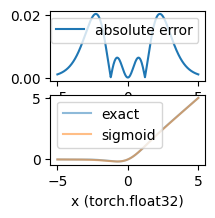

In [6]:
def gelu_sigmoid_approximation(x: t.Tensor) -> t.Tensor:
    """Return sigmoid approximation of GELU of input tensor x with same shape."""
    return x * t.sigmoid(1.702 * x)

def plot_gelu_approximation(x: t.Tensor):
    (fig, (ax0, ax1)) = plt.subplots(nrows = 2, figsize = (2, 2))
    actual = F.gelu(x)
    approx = gelu_sigmoid_approximation(x)
    diff = (actual - approx).abs()
    x_cpu = x.cpu()
    ax0.plot(x_cpu, diff.cpu(), label="absolute error")
    ax0.legend()
    ax1.plot(x_cpu, actual.cpu(), label="exact", alpha=0.5)
    ax1.plot(x_cpu, approx.cpu(), label="sigmoid", alpha=0.5)
    ax1.legend()
    ax1.set(xlabel=f"x ({x.dtype})")
    
x = t.linspace(-5, 5, 400)
plot_gelu_approximation(x)
if t.cuda.is_available():
    x16 = t.linspace(-5, 5, 400, dtype=t.float16, device=device)
    plot_gelu_approximation(x16)
    

class CLIPMLP(nn.Module):
    fc1: nn.Linear
    fc2: nn.Linear
        
    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        """Initialize parent class, then assign fully-connected layers based
        on shape in input config"""
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        """Run forward pass of MLP, including fully-connected layers and non-linear
        activations where appropriate"""
        x = self.fc1(x)
        x = gelu_sigmoid_approximation(x)
        x = self.fc2(x)
        return x
        
test_mlp(CLIPMLP)

In [7]:
class CLIPAttention(nn.Module):
    num_heads: int
    head_size: int
    q_proj: nn.Linear
    k_proj: nn.Linear
    v_proj: nn.Linear
    out_proj: nn.Linear
    dropout: nn.Dropout

    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        """Assign values from input config to class member variables as appropriate"""
        "SOLUTION"
        super().__init__()
        self.num_heads = config.num_attention_heads
        assert config.hidden_size % config.num_attention_heads == 0
        self.head_size = config.hidden_size // config.num_attention_heads
        self.q_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_size)
        self.k_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_size)
        self.v_proj = nn.Linear(config.hidden_size, config.num_attention_heads * self.head_size)
        self.out_proj = nn.Linear(config.num_attention_heads * self.head_size, config.hidden_size)
        self.dropout = nn.Dropout(config.dropout)

    def attention_pattern_pre_softmax(self, x: t.Tensor) -> t.Tensor:
        """Return the attention pattern after scaling but before softmax.

        pattern[batch, head, q, k] should be the match between a query at sequence position q and a key at sequence position k.
        """
        "SOLUTION"
        B, S, H = x.shape
        Q = self.q_proj(x)
        Q = rearrange(Q, "b seq (head head_size) -> b head seq head_size", head=self.num_heads)
        K = self.k_proj(x)
        K = rearrange(K, "b seq (head head_size) -> b head seq head_size", head=self.num_heads)
        out = einsum("b head seq_q head_size, b head seq_k head_size -> b head seq_q seq_k", Q, K)
        out = out / (self.head_size**0.5)
        assert out.shape == (B, self.num_heads, S, S)
        return out

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Perform forward pass through attention layer, computing attention pattern and value projections
        to combine into output. Remember to apply dropout."""
        "SOLUTION"
        B, S, H = x.shape
        attention_pattern = self.attention_pattern_pre_softmax(x)
        softmaxed_attention = attention_pattern.softmax(dim=-1)
        V = self.v_proj(x)
        V = rearrange(V, "b seq (head head_size) -> b head seq head_size", head=self.num_heads)
        combined_values = einsum(
            "b head seq_k head_size, b head seq_q seq_k -> b head seq_q head_size",
            V,
            softmaxed_attention,
        )
        out = self.out_proj(rearrange(combined_values, "b head seq head_size -> b seq (head head_size)"))
        out = self.dropout(out)
        assert out.shape == (B, S, H)
        return out
test_vision_attention(CLIPAttention)

__main__.test_vision_attention passed in 0.07s.


In [8]:
class CLIPEncoderLayer(nn.Module):
    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = CLIPAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim)
        self.mlp = CLIPMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim)

    def forward(self, x):
        x = x + self.self_attn(self.layer_norm1(x))
        x = x + self.mlp(self.layer_norm2(x))
        return x
    

In [9]:
class CLIPEncoder(nn.Module):
    layers: StaticModuleList[CLIPEncoderLayer]

    def __init__(self, config: Union[CLIPVisionConfig, CLIPTextConfig]):
        super().__init__()
        self.layers = StaticModuleList([CLIPEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, x: t.Tensor) -> t.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
class CLIPVisionTransformer(nn.Module):
    config: CLIPVisionConfig
    embeddings: CLIPVisionEmbeddings
    pre_layrnorm: nn.LayerNorm
    encoder: CLIPEncoder
    post_layernorm: nn.LayerNorm

    def __init__(self, config: CLIPVisionConfig):
        """Assign values from input config to class member variables as appropriate"""
        "SOLUTION"
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = CLIPVisionEmbeddings(config)
        self.pre_layrnorm = nn.LayerNorm(embed_dim)
        self.encoder = CLIPEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Perform forward pass through vision transformer: embedding, layer norm, encoder, layer norm
        Return output corresponding to prepended class_embedding"""
        "SOLUTION"
        x = self.embeddings(x)
        x = self.pre_layrnorm(x)
        x = self.encoder(x)
        x = x[:, 0]
        x = self.post_layernorm(x)
        return x
    
test_vision_transformer(CLIPVisionTransformer)

__main__.test_vision_transformer passed in 6.28s.


In [11]:
tokenize = get_reference_model().tokenize

In [12]:
class CLIPModel(nn.Module):
    config: CLIPConfig
    text_config: CLIPTextConfig
    vision_config: CLIPVisionConfig
    projection_dim: int
    text_embed_dim: int
    vision_embed_dim: int
    text_model: modeling_clip.CLIPTextTransformer
    vision_model: CLIPVisionTransformer
    visual_projection: nn.Linear
    text_projection: nn.Linear
    logit_scale: nn.Parameter

    def __init__(self, config: CLIPConfig):
        """Assign values from input config to class member variables as appropriate.

        The typechecker will complain when passing our CLIPTextConfig to CLIPTextTransformer, because the latter expects type transformers.models.clip.configuration_clip.CLIPTextConfig. You can ignore this as our type is in fact compatible.
        """
        "SOLUTION"
        super().__init__()
        self.config = config
        text_config = config.text_config
        vision_config = config.vision_config

        self.projection_dim = config.projection_dim
        self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size

        self.text_model = modeling_clip.CLIPTextTransformer(text_config)  # type: ignore - this is compatible
        self.vision_model = CLIPVisionTransformer(vision_config)

        self.visual_projection = nn.Linear(self.vision_embed_dim, self.projection_dim, bias=False)
        self.text_projection = nn.Linear(self.text_embed_dim, self.projection_dim, bias=False)
        self.logit_scale = nn.Parameter(t.ones([]) * self.config.logit_scale_init_value)

    def forward(self, input_ids, attention_mask, pixel_values) -> CLIPOutput:
        """
        Perform forward pass through CLIP model, applying text and vision model/projection.

        input_ids: (batch, sequence)
        attention_mask: (batch, sequence). 1 for visible, 0 for invisible.
        pixel_values: (batch, channels, height, width)
        """
        "SOLUTION"
        # TBD t.linalg.vector_norm instead
        vis = self.vision_model(pixel_values)
        vis = self.visual_projection(vis)
        vis = vis / vis.norm(p=2, dim=-1, keepdim=True)
        text = self.text_model(input_ids, attention_mask).pooler_output
        text = self.text_projection(text)
        text = text / text.norm(p=2, dim=-1, keepdim=True)
        return CLIPOutput(text, vis)
    

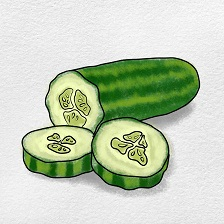

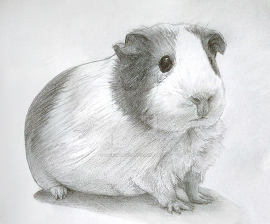

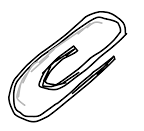

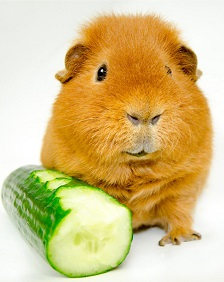

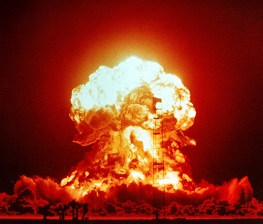

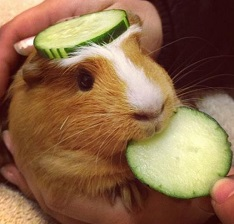

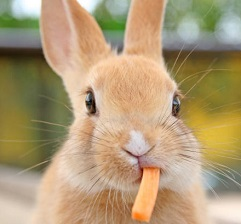

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:


def get_images(glob_fnames: str) -> tuple[list[str], list[Image.Image]]:
    filenames = glob.glob(glob_fnames)
    images = [Image.open(filename).convert("RGB") for filename in filenames]
    image_names = [os.path.splitext(os.path.basename(filename))[0] for filename in filenames]
    for im in images:
        display(im)
    return (image_names, images)


preprocess = cast(
        Callable[[Image.Image], t.Tensor],
        transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        ),
)
texts = [
        "A guinea pig eating a cucumber",
        "A pencil sketch of a guinea pig",
        "A rabbit eating a carrot",
        "A paperclip maximizer",
]
out = tokenize(texts)
input_ids = out["input_ids"]
attention_mask = out["attention_mask"]
(image_names, images) = get_images("/kaggle/input/clip-images/clip_images/*")
pixel_values = t.stack([preprocess(im) for im in images], dim=0)

In [16]:
def cosine_similarities(a: t.Tensor, b: t.Tensor) -> t.Tensor:
    """Return cosine similarities between all pairs of embeddings.

    Each element of the batch should be a unit vector already.

    a: shape (batch_a, hidden_size)
    b: shape (batch_b, hidden_size)
    out: shape (batch_a, batch_b)
    """
    return a @ b.T

test_cosine_similarity(cosine_similarities)

__main__.test_cosine_similarity passed in 0.00s.


In [17]:
def load_trained_model(config: CLIPConfig):
    model = CLIPModel(config)
    full_state_dict = get_reference_clip_model().state_dict()
    model.load_state_dict(full_state_dict)
    return model

config = CLIPConfig(CLIPVisionConfig(), CLIPTextConfig())
model = load_trained_model(config).to(device)
with t.inference_mode():
    out = model(input_ids.to(device), attention_mask.to(device),
               pixel_values.to(device))
similarities = cosine_similarities(out.text_embeds, out.image_embeds)
df = pd.DataFrame(similarities.detach().cpu().numpy(),
                 index = texts, columns = image_names).round(3)
display(df)

,cucumber,guineapig_drawing,paperclip,guineapig_cucumber,explosion,guineapig_cucumber2,bunny
A guinea pig eating a cucumber,0.180,0.222,0.150,0.302,0.117,0.323,0.152
A pencil sketch of a guinea pig,0.145,0.342,0.176,0.221,0.097,0.224,0.121
A rabbit eating a carrot,0.105,0.155,0.150,0.177,0.125,0.187,0.306
A paperclip maximizer,0.104,0.151,0.281,0.117,0.169,0.130,0.154


In [21]:
def contrastive_loss(text_embeds: t.Tensor, image_embeds: t.Tensor, logit_scale: t.Tensor) -> t.Tensor:
    """Return the contrastive loss between a batch of text and image embeddings.

    The embeddings must be in order so that text_embeds[i] corresponds with image_embeds[i].

    text_embeds: (batch, output_dim)
    image_embeds: (batch, output_dim)
    logit_scale: () - log of the scale factor to apply to each element of the similarity matrix

    Out: scalar tensor containing the loss
    """
    similarity = t.matmul(text_embeds, image_embeds.t()) * logit_scale.exp()
    text_loss = F.cross_entropy(similarity.T, t.arange(len(similarity.T)))
    image_loss = F.cross_entropy(similarity, t.arange(len(similarity)))
    return (text_loss + image_loss) / 2.0

test_contrastive_loss(contrastive_loss)

__main__.test_contrastive_loss passed in 0.00s.
